# Forecasting taxi orders

The company "Chetenkoe taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak traffic, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should not exceed 48.

You need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is stored in the `taxi.csv' file. The number of orders is in the `num_orders` column (from English *number of orders*, "number of orders").

## Importing libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, cv
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

## Preparation

### Uploading data

In [12]:
#загружаю датасет
data = pd.read_csv('taxi.csv')
    
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Resampling data by one hour

In [15]:
#признак datetime делаю индексом
data = data.set_index('datetime')
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [17]:
#меняю тип данных на datetime
data.index = pd.to_datetime(data.index)

In [19]:
#ресемплирую данные
data = data.resample('1H').sum()
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51976/878357247.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [24]:
#возьму первую неделю и построю по ней графики
data_week = data['2018-03-05':'2018-03-11']

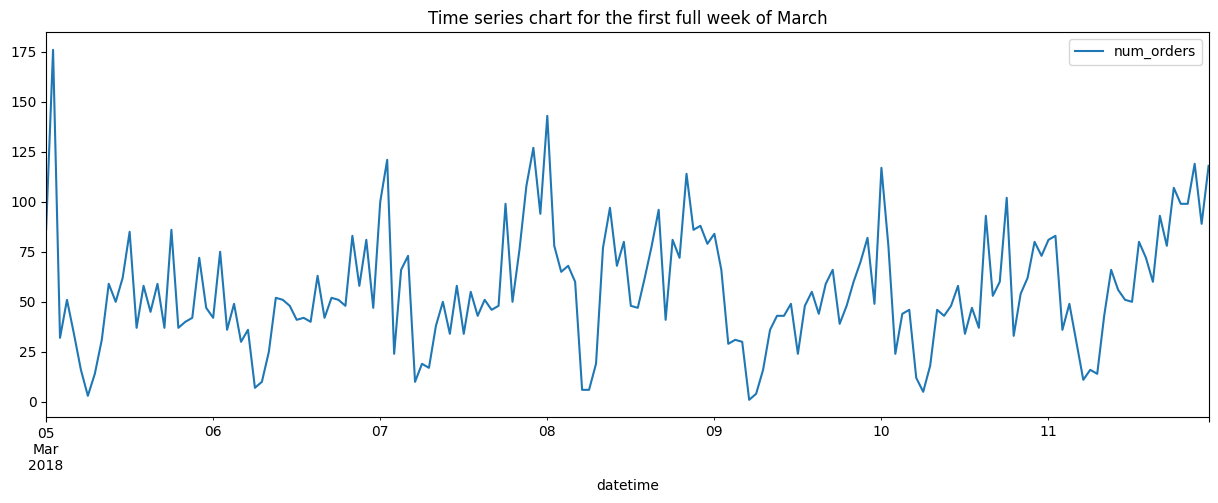

In [26]:
#строю график по данным
data_week.plot(figsize=(15, 5));
plt.title('Time series chart for the first full week of March');

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51976/3694036190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_week['rolling_mean'] = data_week.rolling(7).mean()


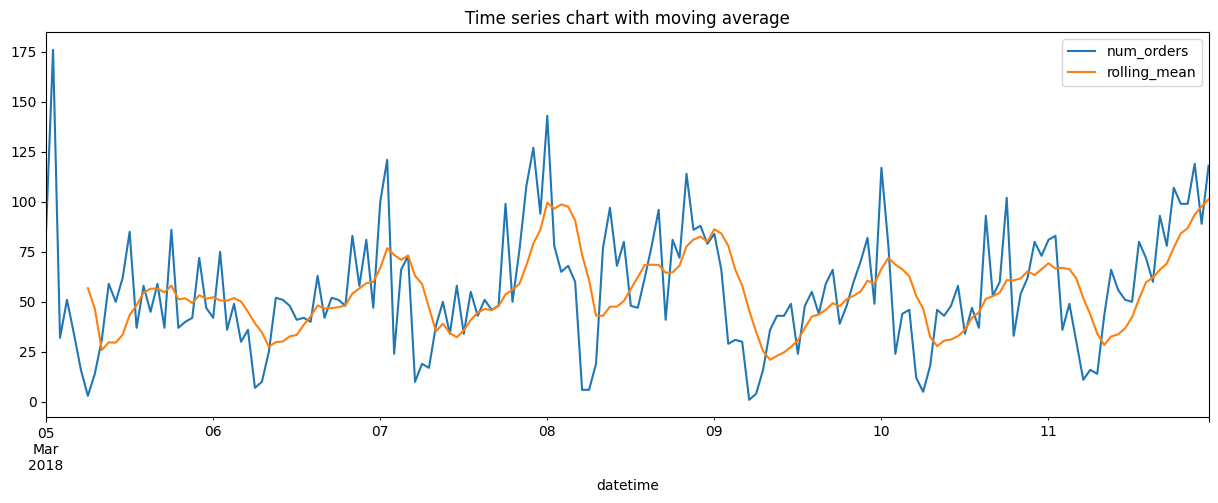

In [28]:
#строю скользящую среднюю
data_week['rolling_mean'] = data_week.rolling(7).mean()
data_week.plot(figsize=(15, 5));
plt.title('Time series chart with moving average');

In [30]:
%config InlibeBackend.figure_format='retina'

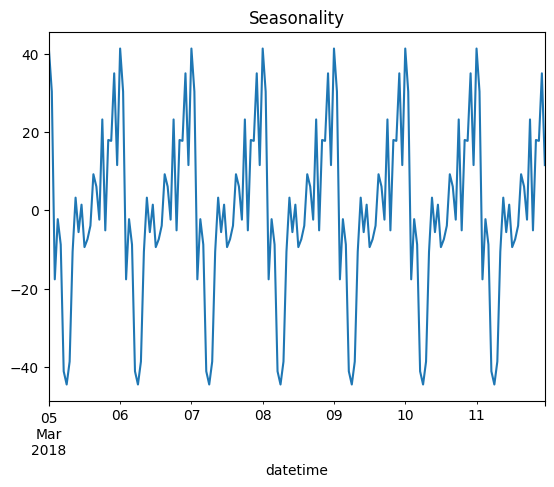

In [32]:
#построю график сезонности
decomposed = seasonal_decompose(data_week['num_orders'])
decomposed.seasonal.plot(ax=plt.gca());
plt.title('Seasonality');

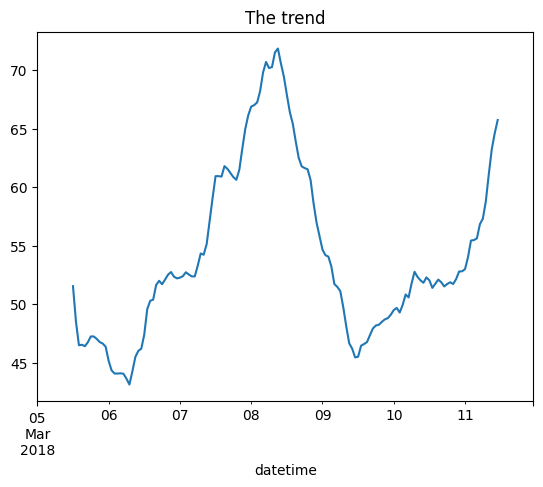

In [34]:
#построю график тренда
decomposed.trend.plot(ax=plt.gca());
plt.title('The trend');

In [36]:
#возьму первый месяц и построю по нему графики
data_month = data['2018-04-01':'2018-04-30']

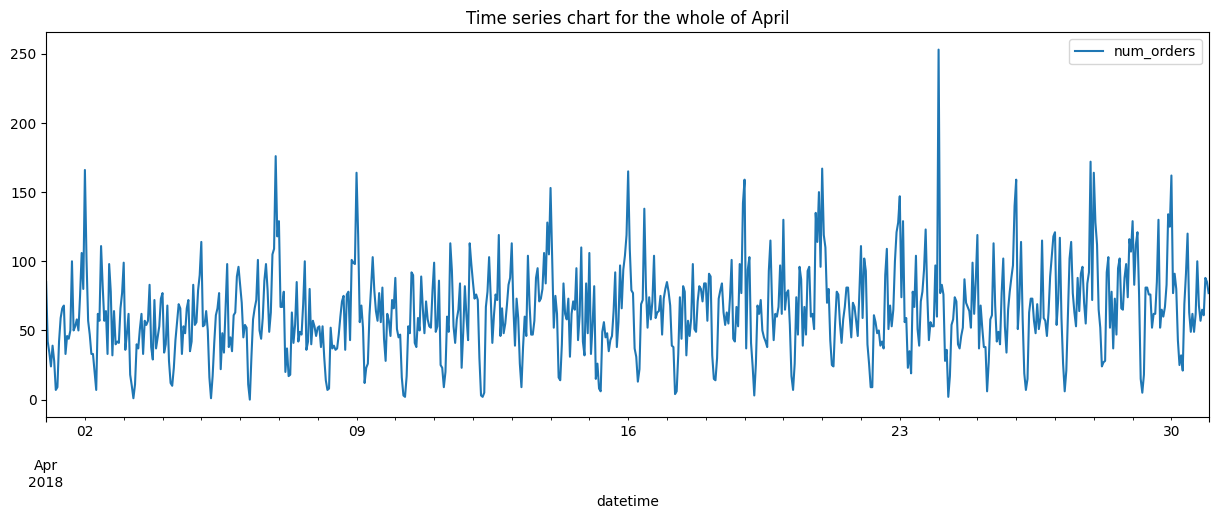

In [38]:
data_month.plot(figsize=(15, 5));
plt.title('Time series chart for the whole of April');

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51976/3028799846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_month['rolling_mean'] = data_month.rolling(10).mean()


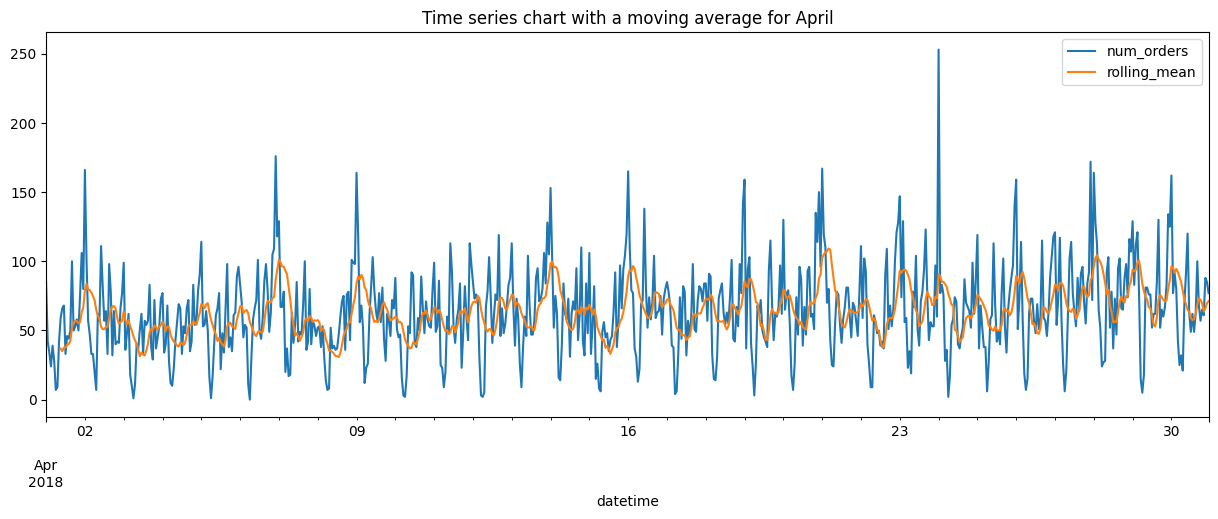

In [40]:
#строю скользящую среднюю
data_month['rolling_mean'] = data_month.rolling(10).mean()
data_month.plot(figsize=(15, 5));
plt.title('Time series chart with a moving average for April');

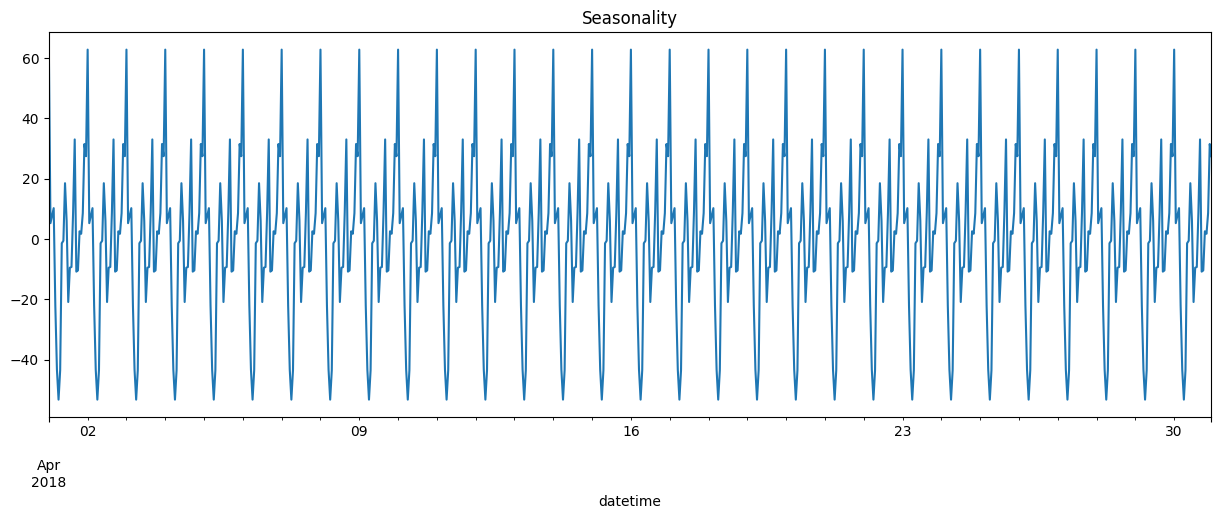

In [42]:
#построю график сезонности
decomposed = seasonal_decompose(data_month['num_orders'])
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 5));
plt.title('Seasonality');

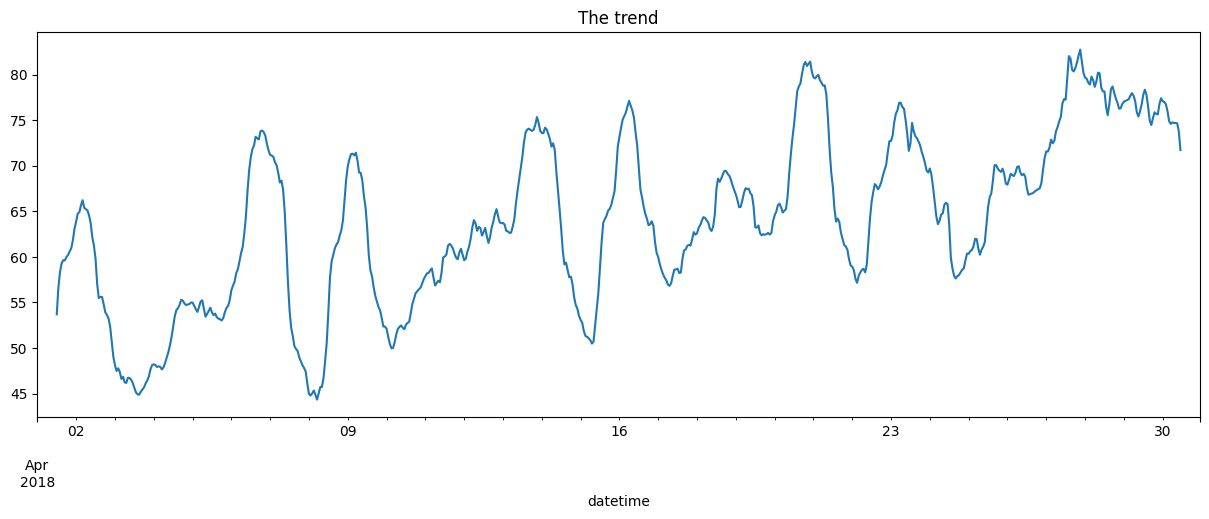

In [44]:
#построю график тренда
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 5));
plt.title('The trend');

### Conclusion: Deleted the null values. Then I created a separate table for one week of March. From the seasonal and trend charts, you can see that taxis are most in demand in the evening, and the most popular day of the week is Thursday. And if you look at the trend chart for one month, you can see that demand is increasing every week. That is, at the end of the month, people order more taxis than at the beginning of the month.

## Preparing data for training

In [48]:
#функция для создания дополнительных признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [50]:
#вызываю функцию
data = make_features(data, 100, 20)

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51976/350252396.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51976/350252396.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51976/350252396.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

In [52]:
#удалю пропущенные значения
data = data.dropna()
data

,num_orders,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,5,4,51.0,32.0,176.0,86.0,68.0,83.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.55
2018-03-05 05:00:00,16,0,5,5,34.0,51.0,32.0,176.0,86.0,68.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,60.30
2018-03-05 06:00:00,3,0,5,6,16.0,34.0,51.0,32.0,176.0,86.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,59.15
2018-03-05 07:00:00,14,0,5,7,3.0,16.0,34.0,51.0,32.0,176.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.35
2018-03-05 08:00:00,31,0,5,8,14.0,3.0,16.0,34.0,51.0,32.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,57.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,31,19,207.0,217.0,197.0,116.0,133.0,166.0,...,157.0,173.0,152.0,96.0,152.0,111.0,182.0,165.0,195.0,169.35
2018-08-31 20:00:00,154,4,31,20,136.0,207.0,217.0,197.0,116.0,133.0,...,192.0,157.0,173.0,152.0,96.0,152.0,111.0,182.0,165.0,163.85
2018-08-31 21:00:00,159,4,31,21,154.0,136.0,207.0,217.0,197.0,116.0,...,133.0,192.0,157.0,173.0,152.0,96.0,152.0,111.0,182.0,157.75


In [54]:
#разделяю данные на выборки
features = data.drop(labels='num_orders', axis=1)
target = data['num_orders']
features_train, features_temporary, target_train, target_temporary = train_test_split(features, target,
                                                                                      test_size=0.35, shuffle=False)
features_valid, features_test, target_valid, target_test = train_test_split(features_temporary, target_temporary, 
                                                                           test_size=0.3, shuffle=False)
#проверяю размеры
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
target_test.shape

(2805, 104)

(2805,)

(1057, 104)

(1057,)

(454, 104)

(454,)

### Conclusion: The data is ready for learning

## Training

In [25]:
#начну с дерева решений
grid_space = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
             'max_features':[1, 3, 5, 7],
             'min_samples_leaf':[2, 3, 4], 
             'min_samples_split':[2, 3, 4],
             'random_state':[12345]}
#создаю модель
model = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(model, param_grid=grid_space, cv=tscv, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

{'max_depth': 5,
 'max_features': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 12345}

In [26]:
model = DecisionTreeRegressor(**best_parametrs)
model.fit(features_train, target_train)
predict = model.predict(features_valid)
display(f'MSE The decision tree: {sqrt(mean_squared_error(target_valid, predict))}')

'MSE Дерева решения: 36.58586682623092'

In [27]:
#теперь случайный лес
grid_space = {'max_depth':[1, 2, 3, 4, 5],
             'n_estimators':[10, 20, 30, 40, 50],
             'random_state':[12345]}
#создаю модель
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(model, param_grid=grid_space, cv=tscv, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

{'max_depth': 5, 'n_estimators': 50, 'random_state': 12345}

In [28]:
model = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=12345)
model.fit(features_train, target_train)
predict = model.predict(features_valid)
display(f'MSE Random Forest: {sqrt(mean_squared_error(target_valid, predict))}')

'MSE Случайный лес: 30.075143038537334'

In [29]:
#теперь линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_valid)
display(f'MSE Linear regression: {sqrt(mean_squared_error(target_valid, predict))}')

'MSE Линейная регрессия: 27.409121151926072'

In [31]:
#теперь проверю catboost
#ищу наилучшее количество итераций с помощью кроссвалидации
tscv = TimeSeriesSplit(n_splits=5)
model = CatBoostRegressor()
#создаю словарь параметров и подбираю learning_rate
grid_space = {'learning_rate':np.arange(0, 0.5, 0.1),
              'iterations':range(100, 1001, 200),
              'verbose':[1000]
             }
grid = GridSearchCV(model, param_grid=grid_space, cv=tscv, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

0:	learn: 28.2573247	total: 1.17ms	remaining: 116ms
99:	learn: 8.2896933	total: 117ms	remaining: 0us
0:	learn: 27.8464485	total: 2.25ms	remaining: 222ms
99:	learn: 10.6164996	total: 140ms	remaining: 0us
0:	learn: 29.5573757	total: 1.52ms	remaining: 151ms
99:	learn: 12.5179341	total: 154ms	remaining: 0us
0:	learn: 30.5400054	total: 3.45ms	remaining: 342ms
99:	learn: 13.9340475	total: 168ms	remaining: 0us
0:	learn: 31.4842475	total: 2.43ms	remaining: 241ms
99:	learn: 14.8397584	total: 179ms	remaining: 0us
0:	learn: 27.2339096	total: 1.95ms	remaining: 193ms
99:	learn: 3.4459318	total: 119ms	remaining: 0us
0:	learn: 26.7002465	total: 2.22ms	remaining: 220ms
99:	learn: 6.5181810	total: 138ms	remaining: 0us
0:	learn: 28.4491119	total: 2.12ms	remaining: 210ms
99:	learn: 8.7819381	total: 152ms	remaining: 0us
0:	learn: 29.2110372	total: 3.39ms	remaining: 336ms
99:	learn: 10.0905082	total: 166ms	remaining: 0us
0:	learn: 30.1057418	total: 2.89ms	remaining: 286ms
99:	learn: 11.3408599	total: 175ms

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^

299:	learn: 9.9445027	total: 554ms	remaining: 0us


{'iterations': 300, 'learning_rate': 0.1, 'verbose': 1000}

In [32]:
params = {'iterations': 300,
         'eval_metric':'MAPE',
         'loss_function':'RMSE',
         'learning_rate':0.1,
         'random_seed':2007, 
         'verbose':1000}
#создаю модель
model = CatBoostRegressor(**params)
model.fit(features_train, target_train)
predict = model.predict(features_valid)
display(f'MSE catboost: {sqrt(mean_squared_error(target_valid, predict))}')

0:	learn: 0.8673980	total: 5.59ms	remaining: 1.67s
299:	learn: 0.1730774	total: 569ms	remaining: 0us


'MSE catboost: 28.541359270629737'

### Conclusion: Linear regression performed best, so I will predict the test sample based on it.

## Testing

In [33]:
#считаю RMSE на тестовой выборке
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_test)
display(f'RMSE on the test sample: {sqrt(mean_squared_error(target_test, predict))}')

'RMSE на тестовой выборке: 42.26901870400936'

### General Conclusion: Uploaded the data, resampled it one day at a time. The date column became the index. Then I took the first full week in March (Mon-Sun) and conducted an analysis. You might have noticed that the most popular day is Thursday, and the most popular time of day is evening. It can also be said that taxis are becoming more popular towards the end of the month. Then I added new features and divided the data into training samples. Next, I tested five models, and Linear regression performed best, so I tested the test sample on it. The RMSE value is 42, so we can say that all the conditions are met.